# Случайные процессы. Прикладной поток.
## Практическое задание 2

**Правила:**

* Выполненную работу нужно отправить на почту `probability.diht@yandex.ru`, указав тему письма `"[СП17] Фамилия Имя - Задание 2"`. Квадратные скобки обязательны. Вместо `Фамилия Имя` нужно подставить свои фамилию и имя.
* Прислать нужно ноутбук и его pdf-версию. Названия файлов должны быть такими: `2.N.ipynb` и `2.N.pdf`, где `N` - ваш номер из таблицы с оценками.
* Никакой код из данного задания при проверке запускаться не будет.

In [64]:
import numpy as np
import scipy.stats as sps
from collections import Counter  # это может пригодиться
from BranchingProcess import Person, BranchingProcess, read_from_files

from statsmodels.sandbox.stats.multicomp import multipletests
from math import factorial, exp
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'font.size': 16})
%matplotlib inline

Считаем данные.

In [3]:
processes = read_from_files(["data/D.txt", "data/W.txt", "data/S.txt", 
                             "data/I.txt", "data/N.txt", "data/O.txt", 
                             "data/K.txt", "data/J.txt", "data/M.txt", 
                             "data/G.txt"])
print(len(processes))

76628


В имеющихся данных очень много людей, про которых известно лишь то, что они когда-то существовали. Обычно их фамилия неизвестна (вместо фамилии у них может стоять, к примеру, `B-290`), а у некоторых из них неизвестен даже пол, не говоря уже о родителях и детях. Такие данные стоит удалить.

Удалим все процессы, состоящие только из одного поколения (в котором, естественно, будет только один человек).

In [4]:
for i in range(len(processes))[::-1]:
    if len(processes[i].generations) < 2:
        del processes[i]

print(len(processes))

22166


## Оценка закона размножения

Чтобы проводить какой-либо анализ ветвящегося процесса нужно некоторым образом оценить закон размножения. Кажется,  что для этого достаточно посчитать количество сыновей у каждого человека, получив тем самым выборку неотрицательных целых чисел. Однако, проблема в том, что данные неполные, в частности, некоторые поля могут быть не заполнены. Тем не менее обычно у человека указаны либо все дети, либо не указаны вообще. 
Таким образом, условно мы можем разделить выборку на две части: поле детей заполнено (в т.ч. если у человека на самом деле нет детей), поле детей незаполнено. Если бы первая часть выборки была бы полностью известна, что распределение можно оценить по ней. Нам же неизвестен размер выборки и количество нулевых элементов в ней. Количество положительных элементов известно.


**Математическая постановка задачи**

$\mathsf{P}_\theta$ --- неизвестное распределение из некоторого класса распределений $\mathcal{P}$ на $\mathbb{Z}_+$.

$X_1, ..., X_n$ --- выборка из распределения $\mathsf{P}_\theta$, причем $n$ и количество нулей в выборке неизвестны. 

$Y_1, ..., Y_s$ --- положительная подвыборка, которая полностью нам известна. В нашей задаче $Y_j$ --- количество сыновей у $j$-го человека среди тех, у кого есть хотя бы один сын.

Оценку параметра $\theta$ можно найти методом максимального правдоподобия:

$$\prod_{i=1}^s \mathsf{P}_\theta (Y_i \left| Y_i > 0 \right) \to \max_\theta$$ 

** Геометрическое распределение **

Функция вероятности геометрического распределения есть

$$p_{\theta}(k) = p(1 - p)^{k},$$

где $k$ - номер первого успеха.

Так как рассматриваются только положительные значения, то будем работать с функцией

$$p_{\theta}(k\ |\ k>0) = p(1-p)^{k-1}$$

Тогда необходимо максимизировать функцию 

$$f = \cfrac{p^{s}(1 - p)^{\sum_{i=1}^{s}Y_{i}}}{(1 - p)^s}$$

Прологарифмировав и взяв производную, получаем

$$L = \cfrac{s}{p} - \cfrac{-s + \sum_{i=1}^{s}Y_{i}}{1 - p}$$

Таким образом, оценкой параметра $\theta$ является $\theta^* = \cfrac{1}{\overline{Y}}$.

In [5]:
def get_theta_all():
    '''
    ОМП для геометрического распределения
    Принцип работы: смотрим на мужчин в i-м
    поколении и на их сыновей в i+1-м
    поколении; количество сыновей заносим в
    массив; ОМП - обратное к среднему 
    '''
    sample = []

    for pedigree in processes:
        for i in range(len(pedigree.generations) - 1):
            for person in pedigree.generations[i]:
                if person.gender == "male" and (len(person.children) > 0):
                    tmp = 0
                    for child in pedigree.generations[i+1]:
                        if child.gender == "male" and \
                        (child.name in person.children):
                            tmp += 1
                    if (tmp != 0):
                        sample.append(tmp)
    
    return 1 / np.mean(sample)

In [6]:
theta_geom = get_theta_all()
print('Оценка параметра для геометрического распределения: ', round(theta_geom, 2))

Оценка параметра для геометрического распределения:  0.46


** Первая часть **

Для того, чтобы найти вероятность вырождения, режим уравнение

$$q = \varphi_{\xi}(q),$$

где $\varphi$ - производящая функция.

Для геометрического распределения имеем

$$ \varphi_{\xi}(z) = \mathbf{E}z^{\xi} = \sum_{m=1}^{\infty} P_{m}z^{m} = \sum_{m=1}^{\infty}(p(1-p)^{m})z^{m} = p \sum_{m=1}^{\infty}((1-p)z)^{m} = \cfrac{p}{1-(1-p)z}$$

$$q = \cfrac{p}{1-(1-p)q} \Longrightarrow q = \cfrac{p}{1-p}I_{\{p\leq\frac{1}{2}\}} + I_{\{p>\frac{1}{2}\}}$$

In [7]:
def count_dgnrcy(p):
    '''
    Функция, вычисляющая вероятность вырождения
    '''
    if (p > 0.5):
        return 1
    else:
        return p / (1 - p)

In [8]:
def get_theta(pedigree):
    '''
    ОМП геометрического распределения для 
    конкретного рода
    Принцип работы: смотрим на мужчин в i-м
    поколении и на их сыновей в i+1-м поколении;
    количество сыновей заносим в массив;
    если длина массива 0 или 10 - 
    - рассматриваем отдельно
    '''
    atomic = []
    
    for i in range(len(pedigree.generations) - 1):
        for person in pedigree.generations[i]:
            if person.gender == "male" and (len(person.children) > 0):
                tmp = 0
                for child in pedigree.generations[i+1]:
                    if child.gender == "male" and \
                    (child.name in person.children):
                        tmp += 1
                if (tmp != 0):
                    atomic.append(tmp)
    
    if len(atomic) == 0:
        return 1
    elif len(atomic) < 10:
        return theta_geom
    else:
        return 1 / np.mean(atomic)

def get_dgnrcy(pedigree):
    '''
    Функция, подсчитывающая вероятность вырождения
    Принцип работы: как предыдущая функция, только
    в конце вызывается функция подсчета вероятности
    вырождения
    '''
    atomic = []
    
    for i in range(len(pedigree.generations) - 1):
        for person in pedigree.generations[i]:
            if person.gender == "male" and (len(person.children) > 0):
                tmp = 0
                for child in pedigree.generations[i+1]:
                    if child.gender == "male" and \
                    (child.name in person.children):
                        tmp += 1
                if (tmp != 0):
                    atomic.append(tmp)
                    
    if len(atomic) == 0:
        return 1
    elif len(atomic) < 10:
        return count_dgnrcy(theta_geom)
    else:
        return count_dgnrcy(1 / np.mean(atomic))

In [9]:
degeneracy = []

for pedigree in processes:
    degeneracy.append(get_dgnrcy(pedigree))

print("Количество процессов, вероятность вырождения которых равна 1: ",
      sum(i==1 for i in degeneracy))
print("Количество процессов, вероятность вырождения которых меньше 0.5: ",
      sum(i<0.5 for i in degeneracy))

Количество процессов, вероятность вырождения которых равна 1:  7335
Количество процессов, вероятность вырождения которых меньше 0.5:  169


** Вторая часть **

** Будем производить моделирование исходя из следующих предположений **:

1. Для каждого рода вычислим среднее время жизни одного поколения. Будем считать, что оно не зависит от номера поколения.
    * В расчетах будем использовать только тех людей, про которых известно все необходимое (они живы и известна их дата рождения)
    * Если таких людей не нашлось, то положим среднее время жизни одного поколения равным 33 годам (так как в реальной жизни 100 лет ~ 3 поколения)
    * Если получится, что между поколениями прошло слишком мало лет (из естественных соображений полагаем, что между поколениями должно пройти хотя бы 18 лет), то положим среднее время жизни между поколениями равным 33 годам.

2. Для каждого рода вычислим, с какого года начинается моделирование.
    * Найдем года рождения всех живых мужчин и возьмем среднее.
    * Если мужчина родился раньше 1900 года, то считаем, что он уже умер.
    * Если мужчин, удовлетворяющих таким условиям нет, то считаем, что процесс выродился.
    
3. В функции model() происходит моделирование для конкретной фамилии.
    * Если некому продолжать род, то считаем, что род выродился.
    * Иначе считаем среднее время жизни и год отсчета.
    * Далее, пока не наступил 2217, происходит само моделирование (генерация детей и переход к следующему поколению)
    * Функция возвращает массив из пар вида <год; число людей в этом году>. Если процесс выродился раньше 2217 года, то массив оборвется раньше, чем 2217 год. Иначе массив будет "полным".

In [196]:
def geom_rvs(theta, size_):
    '''
    Генерация точек геометрического распределения
    '''
    return sps.geom.rvs(theta, loc=-1, size=size_)

In [197]:
def lifetime(pedigree):
    '''
    Функция, вычисляющая среднюю длину жизни между поколениями
    Принцип работы: считаем разность средних дат рождения
    для соседних поколений; усредняем по всем парам
    '''
    diff = []
    average = []
    
    for i in range(len(pedigree.generations)):
        ages = []
        
        for person in pedigree.generations[i]:
            if person.birthday != '':
                year = person.birthday.split('-')[0]
                if year != '':
                    ages.append(int(year))
                    
        if ages != []:
            average.append(np.mean(ages))
        else:
            average.append(0)
    
    for i in range(len(pedigree.generations) - 1):
        if average[i+1] != 0 and average[i] != 0 \
        and average[i+1] - average[i] >= 18:
            diff.append(int(average[i+1] - average[i]))
        else:
            diff.append(33)
    
    return int(np.mean(diff))
            
def get_year(pedigree):
    '''
    Функция, вычисляющая, с какого года следует
    начать моделировать процесс
    Принцип работы: усредняем года рождения всех
    живых мужчин
    '''
    ages = []
    last = len(pedigree.generations) - 1
    
    for person in pedigree.generations[last]:
        if person.birthday != '':
            year = person.birthday.split('-')[0]
            if year > '1900':
                ages.append(int(year))
    if ages != []:
        return int(np.mean(ages))
    else:
        return 0

def model(pedigree):
    '''
    Функция, отвечающая за моделирование
    Принцип работы: находим всех живых мужчин;
    определяем, с какого года начнется процесс;
    определяем, какова длина поколения; пока не 
    2217 год - определяем кол-во сыновей
    '''
    successors = []
    last = len(pedigree.generations) - 1
    
    life = lifetime(pedigree)
    
    for person in pedigree.generations[last]:
        if person.gender == 'male' and person.deathdate == '' \
        and person.birthday.split('-')[0] > '1900':
            successors.append(person)
    
    score = len(successors)
    theta = get_theta(pedigree)
    year = get_year(pedigree)
    
    if score == 0 or year == 0:
        return 0 # Означает, что род уже вырожден
    
    answer = [(year, score)]
    
    while year <= (2217 - life):
        x = geom_rvs(theta, score)
        y = sum(x)
        if y == 0:
            return answer # Означает, что род выродился в процессе моделирования
        else:
            score = y
            year += life
            answer.append((year, score))
            
    return answer

** experiment():** Основная функция, которая производит подсчет числа людей и фамилий. 

1. Она 20 раз запускает моделирование для каждого процесса (20, так как если взять большее число, то придется ждать очень долго).
2. Она подсчитывает, сколько людей было в промежутке [1997 + 20t; 1997 + 20(t + 1)].
3. Предполагается, что если человек родился в этом промежутке, то его следует учесть при подсчете. Также считается, что если человек родился раньше, но его дата рождения + среднее время жизни попадает в данный интервал, то его следует учесть.
4. При учетом родов предположения такие же.
5. Никак не учитывается, что могли появляться новые фамилии.
     

In [198]:
def experiment():
    population = []
    pedigrees = []
    
    for j in range(20):
        ppl = np.zeros(int((2217 - 1997)/20), dtype=int)
        alive = np.zeros(int((2217 - 1997)/20), dtype=int)

        for i in range(len(processes)):
            year_low = 1997
            year_high = 2017
            tmp = np.zeros(int((2217 - 1997)/20), dtype=int)
            
            life = lifetime(processes[i])
            
            x = model(processes[i])
            if (x != 0):
                while year_high <= 2217:
                    for i in range(len(x)):
                        if (x[i][0] >= year_low and x[i][0] < year_high) \
                        or (x[i][0] + life >= year_low and x[i][0] < year_high):
                            ppl[int((year_high - 2017) / 20)] += x[i][1]
                            tmp[int((year_high - 2017) / 20)] = 1
                    year_low += 20
                    year_high += 20
                    
            for k in range(len(tmp)):
                if tmp[k] != 0:
                    alive[k] += 1
                    
        population.append(ppl)
        pedigrees.append(alive)
    
    return population, pedigrees

In [199]:
population, pedigrees = experiment()

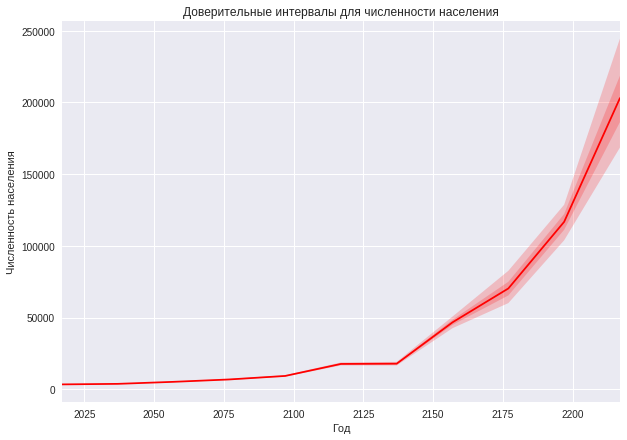

In [200]:
plt.figure(figsize=(10, 7))

time = list(map(lambda t: 2017 + t*20, range(11)))

sns.tsplot(data=population, time = time, ci=[60, 95], color='r')

plt.title('Доверительные интервалы для численности населения')
plt.ylabel('Численность населения')
plt.xlabel('Год')
plt.show()

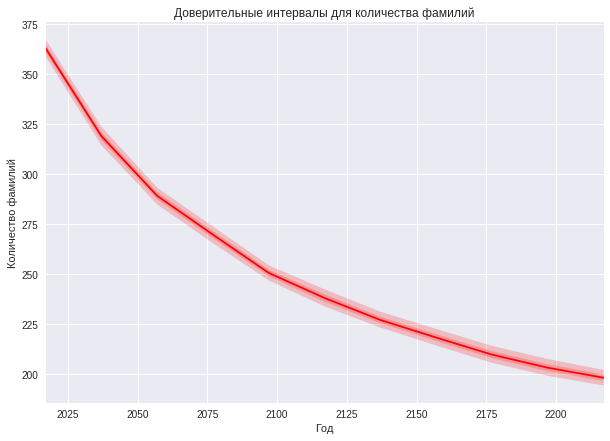

In [201]:
plt.figure(figsize=(10, 7))

time = list(map(lambda t: 2017 + t*20, range(11)))

sns.tsplot(data=pedigrees, time = time, ci=[60, 95], color='r')

plt.title('Доверительные интервалы для количества фамилий')
plt.ylabel('Количество фамилий')
plt.xlabel('Год')
plt.show()

** Вывод: ** С помощью процессов Гальтона-Ватсона смоделировал количество людей к 2217 году. Не использовал регрессии, так как данные были не полные.